# Linear Regression Assumptions

## Objectives:

- Review of how linear regression models work (if needed)
- Understand the five major assumptions of linear regression
- Analyze data to determine if and "by how much" these assumptions are violated 
- Employ fixes to data and/or models to improve performance

## Classical Assumptions of Ordinary Least Squares

We will use this [Duke Resource](http://people.duke.edu/~rnau/testing.htm) as a guide for the lab.

> Note: Duke has the rules in four parts, and other sources can have up to seven rules. Authors can be a bit arbitrary in how they decide to group similar concepts.

1. Regression is linear in parameters & correctly specified (Duke i)
2. The error terms are normally distributed and zero population mean (Duke iv)
3. The error term has constant variance $Var({\epsilon_i})={\sigma^2}$ for every i (Duke iii, no heteroskedasticity)
4. Errors are uncorrelated across observations: $cov({\epsilon_i},{\epsilon_j})=0$ for two observations i and j (Duke ii, no serial correlation)
5. No independent variable is a perfect linear function of any other independent variable (Duke i, no perfect multi-collinearity)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import patsy
import scipy.stats as stats

import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
%matplotlib inline

# Assumption 1: regression is linear in parameters and correctly specified

This is linear: $ Y= {\beta_0}+ {\beta_1}X_1+{\beta_2}X_2 +{\epsilon}$

This is not: $ Y= {\beta_0}+ e^{\beta_1}X^{\beta_2}$

Notice we're not talking about straight lines vs. curved (quadratic or other powers). Rather, the second equation doesn't have scalar coefficients; they change X in strange ways depending on where you are on the axis. Also, we _cannot_ use linear algebra (matrix multiplication) to solve our model for an optimal solution. These 'non-linear models' are a whole different - much more complex - domain of modeling, and outside the scope of this course.

In [2]:
def diagnostic_plot(x, y):
    plt.figure(figsize=(20,5))
    
    rgr = LinearRegression()
    rgr.fit(x,y)
    pred = rgr.predict(x)

    plt.subplot(1, 3, 1)
    plt.scatter(x,y)
    plt.plot(x, pred, color='blue',linewidth=1)
    plt.title("Regression fit")
    plt.xlabel("x")
    plt.ylabel("y")
    
    plt.subplot(1, 3, 2)
    res = y - pred
    plt.scatter(pred, res)
    plt.title("Residual plot")
    plt.xlabel("prediction")
    plt.ylabel("residuals")
    
    plt.subplot(1, 3, 3)
    #Generates a probability plot of sample data against the quantiles of a 
    # specified theoretical distribution 
    stats.probplot(res, dist="norm", plot=plt)
    plt.title("Normal Q-Q plot")

In [3]:
# Generate fake data
s = 500
x = np.random.uniform(low=-5, high=5, size=s)

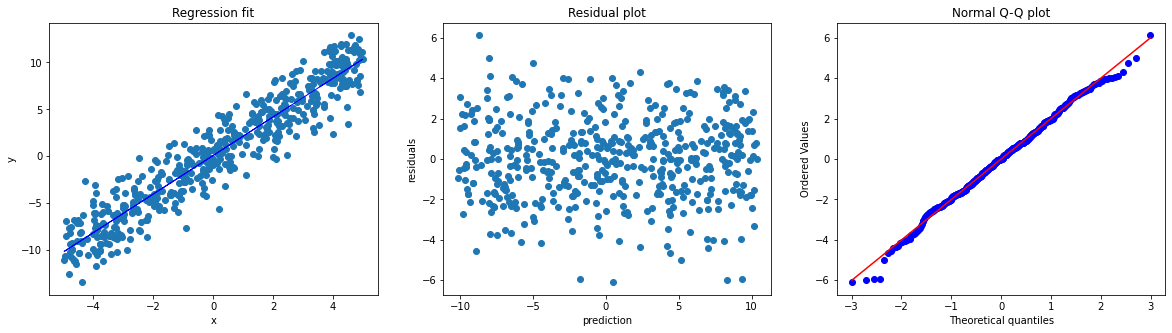

In [4]:
epsilon = 2*np.random.randn(s)
beta = 2
y = beta*x + epsilon

diagnostic_plot(x.reshape(s,1), y) # we reshape x to turn it into a tall column

### Diagnose:

Regression fit: Inspect plot of observed data vs predicted values (points should be symmetric around the line).

Residual plot: Points should be symmetric around y=0 with roughly constant variance. Look carefully for evidence of a "bowed" pattern, indicating that the model makes systematic errors whenever it is making unusually large or small predictions.

Q-Q plot: Look for the middle section of dots to be very close to the diagonal red line. Use the chart below as a reference for interpretation.

![](https://i.stack.imgur.com/ZXRkL.png)

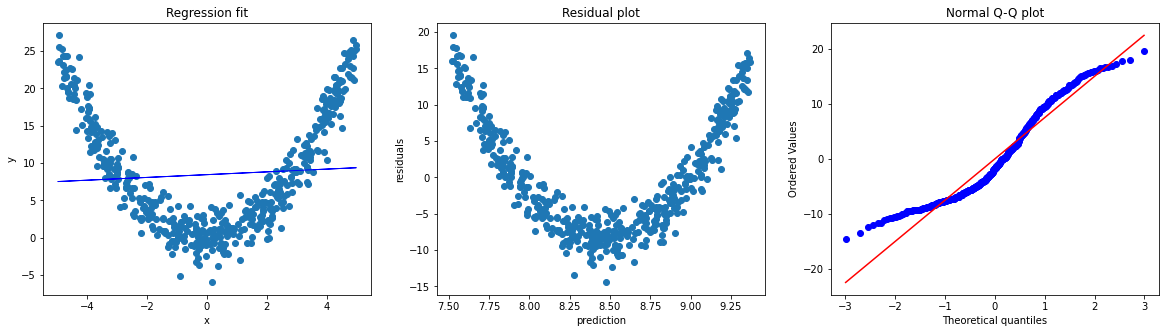

In [5]:
beta1 = 1
y = beta1*(x**2) + epsilon

diagnostic_plot(x.reshape(s,1), y)

Above is an example of broken assumptions for linear models. The model cannot correctly summarize the underlying relationship. If this is true for your data, among other recommendations from Duke and the Additional Resources listed at bottom, you can transform your data to make it more linear using log-transformations or other means, or you may have to utilize a non-linear model on the dataset.

# Assumption 2: residuals ( ${e_i} = Y_i-\hat{Y}_i$ ) should be normally distributed with zero mean

We can check this assumption on a real bikeshare dataset by plotting our residuals vs $\hat{Y}$:

In [6]:
# Let's explore our assumptions - Let's look at some bike data
data = pd.read_csv('./data/hour.csv')

In [7]:
data.describe()

,instant,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,17379.0000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,8690.0000,2.501640,0.502561,6.537775,11.546752,0.028770,3.003683,0.682721,1.425283,0.496987,0.475775,0.627229,0.190098,35.676218,153.786869,189.463088
std,5017.0295,1.106918,0.500008,3.438776,6.914405,0.167165,2.005771,0.465431,0.639357,0.192556,0.171850,0.192930,0.122340,49.305030,151.357286,181.387599
min,1.0000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,4345.5000,2.000000,0.000000,4.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.480000,0.104500,4.000000,34.000000,40.000000
50%,8690.0000,3.000000,1.000000,7.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000,142.000000
75%,13034.5000,3.000000,1.000000,10.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.621200,0.780000,0.253700,48.000000,220.000000,281.000000
max,17379.0000,4.000000,1.000000,12.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,367.000000,886.000000,977.000000


In [8]:
# remove non-numeric data
cols = ['season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'hum', 'windspeed']
X = data[cols]
y = data.cnt   # predictor

In [9]:
# develop OLS with Sklearn
lr = LinearRegression()
fit = lr.fit(X,y) # for later use

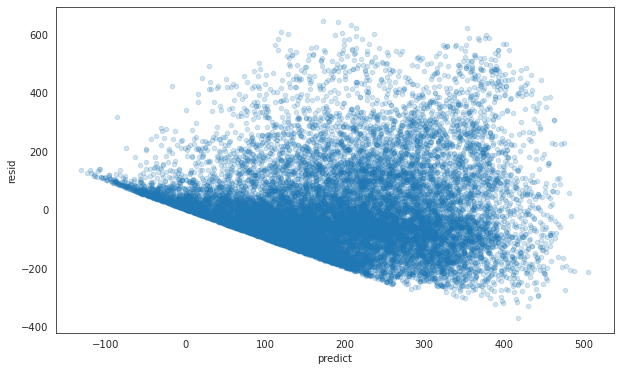

In [10]:
# Plot your predicted values on the x-axis, and your residuals on the y-axis

data['predict']=fit.predict(X)
data['resid']=data.cnt-data.predict
with sns.axes_style('white'):
    plot=data.plot(kind='scatter',
                  x='predict',y='resid',alpha=0.2,figsize=(10,6))

> Question: What is going on with the lower bound of the plot? 

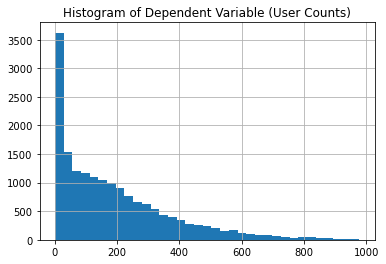

In [11]:
# inspect histogram
data.cnt.hist(bins=35)
plt.title('Histogram of Dependent Variable (User Counts)');

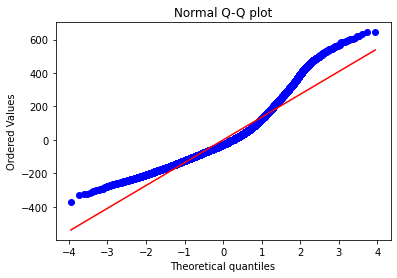

In [12]:
# diagnose/inspect residual normality using qqplot:
stats.probplot(data['resid'], dist="norm", plot=plt)
plt.title("Normal Q-Q plot")
plt.show()

> Answer:

> Note the diagonal pattern in the residuals... the target for our bike dataset is a count of riders, which is NOT continuous: it cannot be negative and must be an integer. It's count data! There is not a truly linear relationship between features and target!

> Therefore, the assumption that errors are normally distributed can't be held (more about count data when we discuss the poisson distribution in a couple of weeks). Remember that our dependent variable should not be categorical or ordinal (i.e. rank of films) either.

# Assumption 3: error terms must have constant variance

In [13]:
# transition to movie data to see a violation of assumption 3
movie=pd.read_csv('./data/2013_movies.csv')

# drop NaNs for quick analysis
movie=movie.dropna()
movie.describe()

,Budget,DomesticTotalGross,Runtime
count,8.700000e+01,8.700000e+01,87.000000
mean,7.545402e+07,1.035153e+08,112.551724
std,5.969168e+07,8.797319e+07,17.854554
min,2.500000e+06,2.556825e+07,80.000000
25%,2.900000e+07,4.793810e+07,98.000000
50%,5.500000e+07,7.162818e+07,113.000000
75%,1.125000e+08,1.238093e+08,123.000000
max,2.250000e+08,4.246680e+08,180.000000


In [14]:
# look at numeric data
X = movie[['Budget','Runtime']]
y = movie.DomesticTotalGross

model = sm.OLS(y,X)
fit = model.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:     DomesticTotalGross   R-squared (uncentered):                   0.703
Model:                            OLS   Adj. R-squared (uncentered):              0.696
Method:                 Least Squares   F-statistic:                              100.8
Date:                Tue, 14 Jul 2020   Prob (F-statistic):                    3.70e-23
Time:                        10:47:49   Log-Likelihood:                         -1699.6
No. Observations:                  87   AIC:                                      3403.
Df Residuals:                      85   BIC:                                      3408.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Budget         0.7377      0.143      5.164      0.000       0.454       1.022
Runtime     4.246e+05    1.2e+05      3.528      0.001    1.85e+05    6.64e+05
==============================================================================
Omnibus:                       38.987   Durbin-Watson:                   0.716
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               95.387
Skew:                           1.592   Prob(JB):                     1.94e-21
Kurtosis:                       7.022   Cond. No.                     1.44e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.44e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

> Note the helpful warnings in `statsmodels`

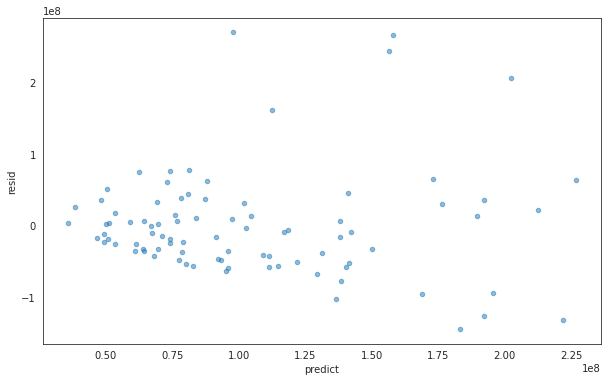

In [15]:
# create residual plot
movie['predict']=fit.predict(X)
movie['resid']= y-movie.predict
with sns.axes_style('white'):
    plot = movie.plot(
        kind='scatter', x='predict', y='resid', alpha=0.5, figsize=(10,6))

> Q: What is wrong with the above plot? Which assumption is this plot inconsistent with? What can we do about it?  

>A: This plot is inconsistent with **Assumption #3**: (The error term must have constant variance).

We see signs of heteroskedasticity; however, the rule of thumb is OLS regression isn't too impacted by heteroscedasticity as long as the maximum variance is not greater than **four** times the minimum variance (as in this case using simple height comparisons across the x-axis). If the residual variance of your model exceeds this range, we can opt for a Weighted Least Squares (WLS) model: http://statsmodels.sourceforge.net/0.6.0/examples/notebooks/generated/wls.html

Here's a resource on [building WLS models in Python](https://towardsdatascience.com/when-and-how-to-use-weighted-least-squares-wls-models-a68808b1a89d).

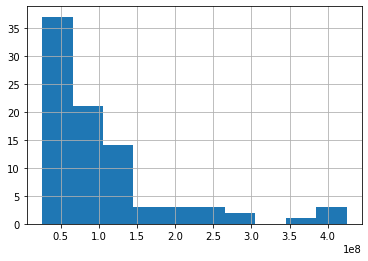

In [16]:
# create histogram
movie.DomesticTotalGross.hist();

# note the positive skew

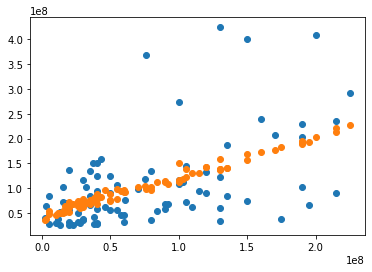

In [17]:
# quick reg plot
plt.scatter(movie.Budget,y)
plt.scatter(movie.Budget,movie.predict);

The predictions are in orange, and they're not able to capture the exponential explosions of some movie profits. We can compress the raw data and see if that helps us model more accurately.

In [ ]:
# try log transformation
np.log(movie.DomesticTotalGross).hist();

# it looks better but not very "normal"

### Let's try another transformation!
Examples of [box-cox in action](http://scikit-learn.org/dev/auto_examples/preprocessing/plot_power_transformer.html) (sklearn calls it power transform) on various distributions.

Note the [scipy transform formula](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.boxcox.html).

In [ ]:
lamb=stats.boxcox_normmax(movie.DomesticTotalGross, brack=(-1.9, 1.9)) # don't use "lambda" as it's a Python reserved word
print("Lambda:", lamb)
y_t=(np.power(movie.DomesticTotalGross,-0.2282)-1)/-0.2282

plt.hist(y_t);

In [ ]:
# plot to show optimal lambda values
fig = plt.figure()
ax = fig.add_subplot(111)
prob = stats.boxcox_normplot(movie.DomesticTotalGross, -3, 5, plot=ax)

You'll note above that `y` peaks at lambda = -.22

It's not perfect... Box-cox can't fix every problem but it will improve things for badly skewed data!

### On your own: 
- Use box-cox transformation to also transform Budget & Runtime
- Visualize residuals on a new model with all features transformed

In [ ]:
# STUDENT SECTION



# Assumption 4: errors are uncorrelated across observations

To check this assumption, let's plot residuals vs. time: 

In [ ]:
# combine date and time into a single datetime column
movie["DATE_TIME"] = pd.to_datetime(movie.ReleaseDate , format="%Y-%m-%d")
movie.head(3)

In [ ]:
ts = movie[['DATE_TIME','resid']].set_index('DATE_TIME')
ts.plot(style=".");

# there seems to be no pattern, so we're good!

Fix: If we did see a strong relationship between errors and time, this would indicate that our model is incorrectly specified. We might apply a time-series model if there's natural [autocorrelation](https://en.wikipedia.org/wiki/Autocorrelation) (a concept introduced later).

# Assumption 5: no independent variable is a perfect linear function of any other independent variable (no perfect multi-collinearity)

Ways to diagnose: 
1. Inspect correlations of independent features
2. Keep an eye on condition number!
    3. As noted above, `statsmodels` will notify you of [large condition numbers](https://en.wikipedia.org/wiki/Condition_number).

Ways to fix:
3. Consider Partial Least Squares or projection into latent space (PCA, introduced in the second-half of the course)
4. Use Ridge regularization

Incorporating [Ridge regularization](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html) not only fixes this issue (if it exists, still safe to use if it doesn't), but it imparts other benefits as well. We'll use Ridge quite often after it's officially introduced!

## Objectives:

- Review of how linear regression models work (if needed)
- Understand the five major assumptions of linear regression
- Analyze data to determine if and "by how much" these assumptions are violated 
- Employ fixes to data and/or models to improve performance

## Additional Resources
- [Duke Guide](http://people.duke.edu/~rnau/testing.htm)
- [10 Assumptions List](http://r-statistics.co/Assumptions-of-Linear-Regression.html)
- [University of Wisconsin List](http://blog.uwgb.edu/bansalg/statistics-data-analytics/linear-regression/what-are-the-four-assumptions-of-linear-regression/)
- [Statistics Solutions Guide](http://www.statisticssolutions.com/assumptions-of-linear-regression/)